* Discussions - 
    * check feasibility of a model trained once and able to predict (like train every 7 days). If not - we can train everyday. 
    * Intent of predicting topics is it to show say pvs last week for a topic vs this week. How far out such comparisons need to be made? -- that will decide the date range of training and prediction -- a week is good strat
    * Keep topic words same but test with lesser number of words
    * Not every article needs to be assigned to a topic. so noise part of hdbscan is fine

**Data product options:**

* Technique 1 - train every 7 days
    * PART 1: Check if day-of-week = Monday :: 
        * Take past 7 days (apr 26 till may 02)
        * Train & store file
        * Get yesterday's topics (may 02) and save that 1 day
        
    * PART 2: Else ::
        * Take yesterday's eligible articles
        * Use the saved cluster file and predict
        * save that 1 day
        * Part 2 will be repeated from tues till sunday of a week
        
    * When loop progresses to day = Monday, execute Part 1, then Part 2 and loop goes on 
    
Note: 
* Caveat - We are training on articles which already have labels (through prediction).   
* Save embeddings - so repeating ones need not be calculated. Plus, they can be used as features in other projects

**Environment issue**:
* On 6/11/2021 upgrading transformers messed up the environment (topics). Recreated using req.txt (called topics-env).
* Imp point to note - for umap, hdbcsan to work, numba>-0.50.x Added this to the req.txt
* transformers library version = 4.3.2 -- add this during deployment if going with topic summarization
* Not deleting topics environment, in case other working library versions need to be consulted 

In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

### Competitor research:
* WSJ uses HDBSCAN - https://medium.com/the-wall-street-journal/staying-on-topic-building-an-automated-topic-model-of-wsj-news-coverage-d4dc4369f71b

In [2]:
from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

In [3]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

In [4]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

In [5]:
results_path = '/home/jupyter/bi-topic-modeling/results/' 
SEED = 42

### --- Data ---

* Train date range Apr 26 (monday) till May 02 (sunday)
* Eligible pool = articles with pvs > 100 on a given day

In [6]:
def get_data(file_name):
    
    df = pd.read_csv(data_path + file_name)

    print("Before Shape:", df.shape)
    print("Unique tiers:", len(df.tier1.unique()))
    
    # Per verdict from EDA, exclude articles less than 100 words
    df["article_length"] = df.clean_body.str.split().apply(len)
    df = df[df["article_length"]>=100]
    print("After Shape:", df.shape)
    
    df.tier1 = df.tier1.fillna('Other')
    df = df.reset_index(drop=True)
    
    return df

In [7]:
# training data set

print("--- apr 25 ---")
apr25 = get_data('processed/train_apr25_over100pvs_processed.csv')
apr25_art_embed = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")
print("Embeds len:", len(apr25_art_embed))

print()
print("--- apr 26 ---")
apr26 = get_data('processed/pred_apr26_over100pvs_processed.csv')
apr26_art_embed = joblib.load("./data/processed/apr26_article_embed_axis0.joblib")
print("Embeds len:", len(apr26_art_embed))

print()
print("--- apr 27 ---")
apr27 = get_data('processed/pred_apr27_over100pvs_processed.csv')
apr27_art_embed = joblib.load("./data/processed/apr27_article_embed_axis0.joblib")
print("Embeds len:", len(apr27_art_embed))

print()
print("--- apr 28 ---")
apr28 = get_data('processed/apr28_over100pvs_processed.csv')
apr28_art_embed = joblib.load("./data/processed/apr28_article_embed_axis0.joblib")
print("Embeds len:", len(apr28_art_embed))

print()
print("--- apr 29 ---")
apr29 = get_data('processed/apr29_over100pvs_processed.csv')
apr29_art_embed = joblib.load("./data/processed/apr29_article_embed_axis0.joblib")
print("Embeds len:", len(apr29_art_embed))

print()
print("--- apr 30 ---")
apr30 = get_data('processed/apr30_over100pvs_processed.csv')
apr30_art_embed = joblib.load("./data/processed/apr30_article_embed_axis0.joblib")
print("Embeds len:", len(apr30_art_embed))

print("--- may 01 ---")
may01 = get_data('processed/may01_over100pvs_processed.csv')
may01_art_embed = joblib.load("./data/processed/may01_article_embed_axis0.joblib")
print("Embeds len:", len(may01_art_embed))

print()
print("--- may 02 ---")
may02 = get_data('processed/may02_over100pvs_processed.csv')
may02_art_embed = joblib.load("./data/processed/may02_article_embed_axis0.joblib")
print("Embeds len:", len(may02_art_embed))

--- apr 25 ---
Before Shape: (3334, 10)
Unique tiers: 31
After Shape: (3327, 11)
Embeds len: 3327

--- apr 26 ---
Before Shape: (4138, 10)
Unique tiers: 31
After Shape: (4128, 11)
Embeds len: 4128

--- apr 27 ---
Before Shape: (4177, 10)
Unique tiers: 31
After Shape: (4167, 11)
Embeds len: 4167

--- apr 28 ---
Before Shape: (4197, 8)
Unique tiers: 31
After Shape: (4186, 9)
Embeds len: 4186

--- apr 29 ---
Before Shape: (4201, 8)
Unique tiers: 31
After Shape: (4188, 9)
Embeds len: 4188

--- apr 30 ---
Before Shape: (3784, 8)
Unique tiers: 31
After Shape: (3771, 9)
Embeds len: 3771
--- may 01 ---
Before Shape: (3052, 8)
Unique tiers: 31
After Shape: (3044, 9)
Embeds len: 3044

--- may 02 ---
Before Shape: (3267, 8)
Unique tiers: 31
After Shape: (3259, 9)
Embeds len: 3259


In [8]:
# testing data set

print()
print("--- may 03 ---")
may03 = get_data('processed/may03_over100pvs_processed.csv')
may03_art_embed = joblib.load("./data/processed/may03_article_embed_axis0.joblib")
print("Embeds len:", len(may03_art_embed))

print()
print("--- may 04 ---")
may04 = get_data('processed/may04_over100pvs_processed.csv')
may04_art_embed = joblib.load("./data/processed/may04_article_embed_axis0.joblib")
print("Embeds len:", len(may04_art_embed))

print()
print("--- may 05 ---")
may05 = get_data('processed/may05_over100pvs_processed.csv')
may05_art_embed = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
print("Embeds len:", len(may05_art_embed))

print("--- may 06 ---")
may06 = get_data('processed/may06_over100pvs_processed.csv')
may06_art_embed = joblib.load("./data/processed/may06_article_embed_axis0.joblib")
print("Embeds len:", len(may06_art_embed))

print("--- may 07 ---")
may07 = get_data('processed/may07_over100pvs_processed.csv')
may07_art_embed = joblib.load("./data/processed/may07_article_embed_axis0.joblib")
print("Embeds len:", len(may07_art_embed))


--- may 03 ---
Before Shape: (4210, 8)
Unique tiers: 31
After Shape: (4199, 9)
Embeds len: 4199

--- may 04 ---
Before Shape: (4235, 8)
Unique tiers: 31
After Shape: (4223, 9)
Embeds len: 4223

--- may 05 ---
Before Shape: (4174, 8)
Unique tiers: 31
After Shape: (4160, 9)
Embeds len: 4160
--- may 06 ---
Before Shape: (4079, 8)
Unique tiers: 31
After Shape: (4063, 9)
Embeds len: 4063
--- may 07 ---
Before Shape: (3644, 8)
Unique tiers: 31
After Shape: (3630, 9)
Embeds len: 3630


* Combine train data - 7 days: apr 26 (monday) till may 2 (sunday)

In [9]:
# # concatenate dfs

# combined_df = pd.concat([apr26, apr27, apr28, apr29, apr30, may01, may02])
# # reset index
# combined_df = combined_df.reset_index(drop=True)
# # drop unnecessary cols
# combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# # fill na
# combined_df.tier2 = combined_df.tier2.fillna('Other')
# combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
# print(combined_df.shape)

# # concatenate embeds
# combined_embeds = apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
# print(len(combined_embeds))

(26743, 9)
26743


In [9]:
# concatenate dfs

combined_df = pd.concat([apr30, may01, may02])
# reset index
combined_df = combined_df.reset_index(drop=True)
# drop unnecessary cols
# combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# fill na
combined_df.tier2 = combined_df.tier2.fillna('Other')
combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
print(combined_df.shape)

# concatenate embeds
combined_embeds = apr30_art_embed + may01_art_embed + may02_art_embed
print(len(combined_embeds))

(10074, 9)
10074


* workflow:
    * take unique articles, train and assign topics -- natid, topic mapping
        * save this in csv and manually analyze for 5-6 topic words
    * for chart, take per day pvs for each article, sum for topic per day and show

In [10]:
# drop duplicates from df

train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

print(train_df.shape)
print(train_df.content_natid.duplicated(keep='first').any())

train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
print(len(train_embeds))

(4645, 9)
False
4645


In [11]:
train_df.reset_index(drop=True, inplace=True)

train_df = train_df[['content_natid', 'clean_body']]
train_df.shape

(4645, 2)

### --- Modeling ---

In [12]:
data = train_df.clean_body.tolist()
print(len(data))

4645


In [13]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, input = sentence embeddings aggregated (mean) to full article

umap_embeddings =  umap.UMAP(n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED,
                            ).fit(train_embeds)

In [14]:
# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                          #cluster_selection_method='leaf', #new
                         # cluster_selection_epsilon = 0.5, #new,
                          min_samples = 4, #new 
                      prediction_data=True).fit(umap_embeddings.embedding_)

In [15]:
print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (4645, 2)


In [17]:
# min_samples =4 (apr26-may02)
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.2996882715864831

In [17]:
# min_samples =4 (apr28-may02)
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.3056134726140488

In [16]:
# min_samples =4 (apr30-may02)
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.3752548848802255

In [17]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 238



,Doc,Topic,Doc_ID
0,10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight g...,26,0
1,the new ipad pro 2021 gets even better with tons of new features announced at wwdc. it was just over a yea...,-1,1
2,the best mattress discounts & bedding sales right now: $800 off at nolah. if youre in the market for a new...,29,2
3,"the best sales online right now: overstock, supergoop and more. now that memorial day weekend is behind us...",29,3
4,"13 pool floats for the whole family (yes, your dog too). theres only so much lemonade you can drink on you...",27,4
...,...,...,...
4640,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...,38,4640
4641,"ten secrets apple does not want you to know. this is a guest post by jonathan zschau, a boston-based attor...",41,4641
4642,"the five richest pastors in nigeria. london-based nigerian pastor matthew ashimolowo god is good, especial...",182,4642
4643,man inadvertently live tweets osama bin laden raid. an it consultant who tried to take a break from the ra...,-1,4643


In [18]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

In [19]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.00040674606959025065


In [20]:
top_n_words_df["topic_words"] = clean_keys

In [21]:
top_n_words_df.tail()

,topic_num,topic_words
233,232,"candidates, salary range, raises, says elliott, sales training, product service"
234,233,"hr, team members, teams, positive culture, leaders, corporate culture"
235,234,"confrontation, gestures, ll, leaders, listen, conversation"
236,235,"thoughts, emotions, negative, feelings, overthinking, emotional"
237,236,"disabled people, happiness, ableism, decisions, says dr, mental"


In [22]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# # per topic - tier counts
# tier_metric = docs_df.join(df[["tier1"]])

# iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
#                                                'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
#                                                                                                     'distinct_tier1s',
#                                                                                                     'Topic':
#                                                                                                     'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [23]:
topic_info.tail()

,topic_num,topic_words,Size,cos_min,cos_mean
233,232,"candidates, salary range, raises, says elliott, sales training, product service",10,0.82,0.90
234,233,"hr, team members, teams, positive culture, leaders, corporate culture",16,0.80,0.90
235,234,"confrontation, gestures, ll, leaders, listen, conversation",12,0.79,0.89
236,235,"thoughts, emotions, negative, feelings, overthinking, emotional",44,0.70,0.90
237,236,"disabled people, happiness, ableism, decisions, says dr, mental",13,0.78,0.89


* Observation on cluter-goodness:
    * Good quality overall - 
        * most articles in a group on avg have 0.85-0.93 cosine similarity which is pretty high
        * min similarity is also 0.7 and above for most topics
        
    * Manual eyeballing - 88 topics good, 19 bad

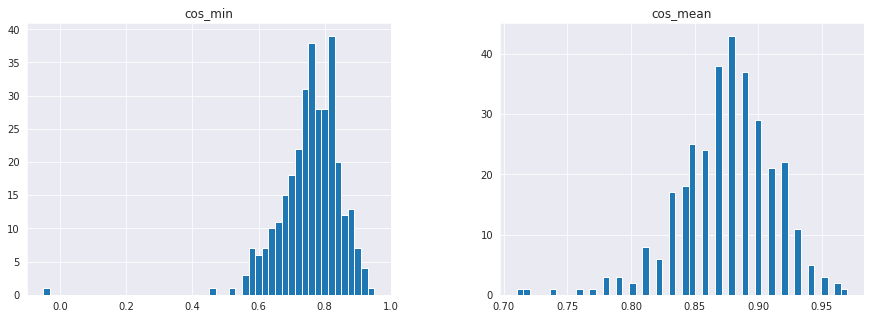

In [25]:
# TEST FOR LESSER NOISE - NEW PARAMS HDBSCAN
topic_info[['cos_min', 'cos_mean']].hist(figsize= (15,5), bins=50)
plt.show()

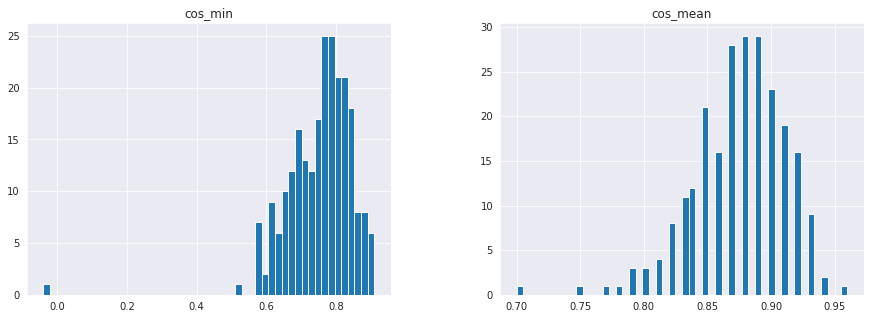

In [24]:
# TEST FOR LESSER NOISE - NEW PARAMS HDBSCAN
topic_info[['cos_min', 'cos_mean']].hist(figsize= (15,5), bins=50)
plt.show()

In [27]:
joblib.dump(umap_embeddings, "./model/apr26_may2_train_umap_obj.joblib")
joblib.dump(cluster, "./model/apr26_may2_train_clusterer_obj.joblib")

['./model/apr26_may2_train_clusterer_obj.joblib']

**Topics are about:**


In [25]:
# combine natural id inside docs_df
docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
docs_df.drop("clean_body", axis=1, inplace=True)

In [26]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,content_natid,topic_num,topic_words,Size,cos_min,cos_mean
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",26,0,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,26,"mattress, pillow, memory foam, sleepers, duvet, bed",23,0.73,0.9


In [29]:
full_train_topics.to_csv(results_path+"apr26_may02_full_train_topics.csv", index=False)

In [30]:
# TEST FOR LESSER NOISE
full_train_topics.to_csv(results_path+"MOD_apr26_may02_full_train_topics.csv", index=False)

In [50]:
topic_info.to_csv("minsamp4.csv", index=False)

In [28]:
topic_info.Size.describe()

count     267.000000
mean       23.138577
std       102.863986
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max      1675.000000
Name: Size, dtype: float64

<AxesSubplot:>

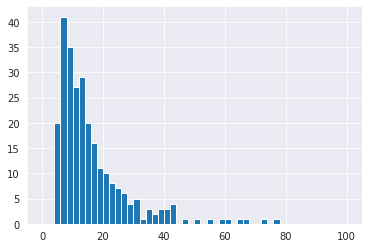

In [29]:
topic_info.Size.hist(bins=50, range=(0,100))

In [30]:
# 200 clustered
round(full_train_topics[full_train_topics.Topic==-1].shape[0]/full_train_topics.shape[0]*100)

27

* **Predict new points/articles - May 3**

In [27]:
# umap_embeddings = joblib.load("./model/apr26_may2_train_umap_obj.joblib")
# cluster = joblib.load("./model/apr26_may2_train_clusterer_obj.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, random_state=42)

HDBSCAN(min_samples=4, prediction_data=True)


**Note:** 
* There will be articles read between Apr 26 - May 02 (training set), which will also be read on May 03. 
* These common articles present in prediction set, will get the same topic cluster as before

**For now:**
* Predict on whole of may03

In [28]:
# dimensionality reduction
umap_embeddings_may03 = umap_embeddings.transform(may03_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may03.shape) #takes a min

Training input shape: (4645, 2)
Prediction input shape: (4199, 2)


In [29]:
# predict

may03_test_labels, may03_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may03)

print(len(may03_test_labels))
# print(set(may03_test_labels))
print(len(set(may03_test_labels)))
# with samples=3, topic=389
# with samples=4 (apr26-may02), topic=310
# with samples=4 (apr28-may02), topic=260
# with samples=4 (apr30-may02), topic=235


4199
235


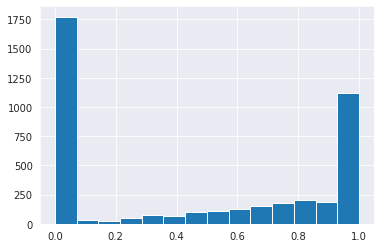

In [34]:
plt.hist(may03_strengths, bins='auto')
plt.show()

* Exploring prediction strength for thresholding

In [35]:
print(len(may03_test_labels))
print(len(may03_strengths))
print(type(may03_strengths))

4199
4199
<class 'numpy.ndarray'>


According to API:

* labels: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.
* probabilities: The strength with which each sample is a member of its assigned cluster. Noise points have probability zero; points in clusters have values assigned proportional to the degree that they persist as part of the cluster.

In [41]:
strength_exp = pd.DataFrame(zip(may03_test_labels, may03_strengths), columns=['Topic', 'Strength'])
strength_exp.head()

,Topic,Strength
0,47,0.847144
1,-1,0.000000
2,-1,0.000000
3,53,0.545595
4,-1,0.000000


In [42]:
strength_exp_agg = strength_exp.groupby('Topic').agg({'Strength':['min', 'mean', 'max']})
strength_exp_agg.columns= strength_exp_agg.columns.droplevel()
strength_exp_agg

,min,mean,max
Topic,,,
-1,0.000000,0.000000,0.000000
0,0.047635,0.490097,1.000000
1,0.006832,0.140931,0.449847
2,0.057022,0.351348,1.000000
3,0.008737,0.344301,1.000000
...,...,...,...
316,0.565737,0.767623,1.000000
317,0.883533,0.908046,0.949289
318,0.647055,0.647055,0.647055


In [32]:
# this gives for training data
temp = hdbscan.prediction.all_points_membership_vectors(cluster)

# this gives for prediction data
temp_pred = hdbscan.prediction.membership_vector(cluster, umap_embeddings_may03)

In [33]:
print("===TRAINING===")
print(np.argmax(temp[0]))
print(temp[0][45])
print()
print(np.argmax(temp[1]))
print(temp[1][42])
print()
print("===PREDICTION===")
print(np.argmax(temp_pred[0]))
print(temp[0][42])

===TRAINING===
45
0.04204195017308981

42
0.09385600636215856

===PREDICTION===
42
0.013022068414443252


# soft clustering

closest_clusters = [np.argmax(x) for x in temp]

probs = []
for i in range(len(temp)):
    probs.append(temp[i][closest_clusters[i]])
print(len(probs))

In [74]:
inspect = docs_df[['Doc', 'Topic']].copy()
inspect['closest_clusters'] = closest_clusters
inspect['closest_cluster_prob'] = probs

[Closest soft clusters and cluster.labels_ do not match](https://stackoverflow.com/questions/44937157/comparing-hdbscan-labels-with-soft-cluster-results)

In [79]:
print(inspect[inspect.Topic==-1].closest_cluster_prob.max())
inspect[inspect.Topic==-1]

0.5755335398862541


,Doc,Topic,closest_clusters,closest_cluster_prob
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,45,0.042042
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the past year at home, forced to stare at the same worn-in couch, threadbare arm chair and sparse wall art. so if youre feeling like its time for ...",-1,51,0.164476
6,"missing paris? visit virtually with a cooking class from la cuisine paris. missing paris? me too. like so many people, paris is my favorite city to visit. when i was in college, i studied for a year in paris and some of my favorite things to do a...",-1,43,0.090587
9,"two nightmare scenarios for bitcoin. cryptocurrencies could be damned if they do get government acceptance, and damned if they dont. yes, thats right, there is a route to oblivion whichever way the cookie crumbles. government crypto ban? heres th...",-1,169,0.036279
10,"luminar partners with airbus on laser lidar sensors for robotic aircraft. luminar, a newly public maker of laser lidar sensors, is stepping beyond self-driving cars to partner with airbus advanced technology arm to determine if 3-d vision improve...",-1,202,0.037338
...,...,...,...,...
7222,"three ways that handwriting with a pen positively affects your brain. stephen king purportedly wrote dreamcatcher in longhand using a waterman cartridge pen. j. k. rowling penned the tales of beedle the bard all 157 pages of it in longhand, and t...",-1,251,0.038611
7224,why art and science are more closely related than you think. (image: creative commons) has an art ever become a science? originally appeared on quora - the knowledge sharing network where compelling questions are answered by people with unique in...,-1,270,0.040133
7225,how kathy ireland built a $420 million fortune. supermodel-turned-mogul kathy ireland today joined forbes' first ever ranking of america's top 50 most successful women as measured by their net worths. ireland is the only licensing queen - and the...,-1,146,0.009392
7226,"what your facebook use reveals about your personality and your self-esteem. every day when facebook asks, what's on your mind? around 400 million people respond with a status message. while some people take the opportunity to share about their la...",-1,171,0.009148


<AxesSubplot:>

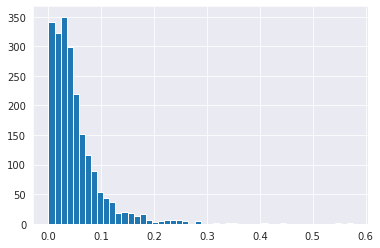

In [82]:
inspect[inspect.Topic==-1].closest_cluster_prob.hist(bins=50)

In [42]:
insp_noise = inspect[inspect.Topic==-1]
print(insp_noise[insp_noise.closest_cluster_prob>0.2].shape)
insp_noise[insp_noise.closest_cluster_prob>0.2]

NameError: name 'inspect' is not defined

In [45]:
print("Matching labels", inspect[inspect.Topic== inspect.closest_clusters].shape)
print("Non-Matching labels", inspect[inspect.Topic != inspect.closest_clusters].shape)

Matching labels (4931, 3)
Non-Matching labels (2307, 3)


In [48]:
inspect[inspect.Topic != inspect.closest_clusters].Topic.value_counts()

-1      2159
 237       9
 87        8
 164       7
 134       6
        ... 
 25        1
 17        1
 3         1
 250       1
 8         1
Name: Topic, Length: 78, dtype: int64

In [30]:
# put topics in dataframe
may03_docs_df = may03[['clean_body']]
may03_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may03_docs_df["Topic"] = may03_test_labels

print("Distinct topics including -1 for noise", len(may03_docs_df.Topic.unique()))
print()
may03_docs_df.tail()

Distinct topics including -1 for noise 235



,Doc,Topic
4194,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4195,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",38
4196,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",103
4197,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,22
4198,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",-1


In [31]:
# put topics in dataframe
may03_docs_df = may03[['clean_body']]
may03_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may03_docs_df["Topic"] = may03_test_labels

print("Distinct topics including -1 for noise", len(may03_docs_df.Topic.unique()))
print()
may03_docs_df.tail()

Distinct topics including -1 for noise 235



,Doc,Topic
4194,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4195,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",38
4196,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",103
4197,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,22
4198,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",-1


In [32]:
may03_topic_sizes = extract_topic_sizes(may03_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may03_cossim_df = generate_all_cossim_metrics(may03_docs_df, umap_embeddings_may03)

# per topic - tier counts
tier_metric = may03_docs_df.join(may03[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may03 = pd.merge(pd.merge(may03_topic_sizes, 
                                        may03_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may03.drop('Topic', axis=1, inplace=True)

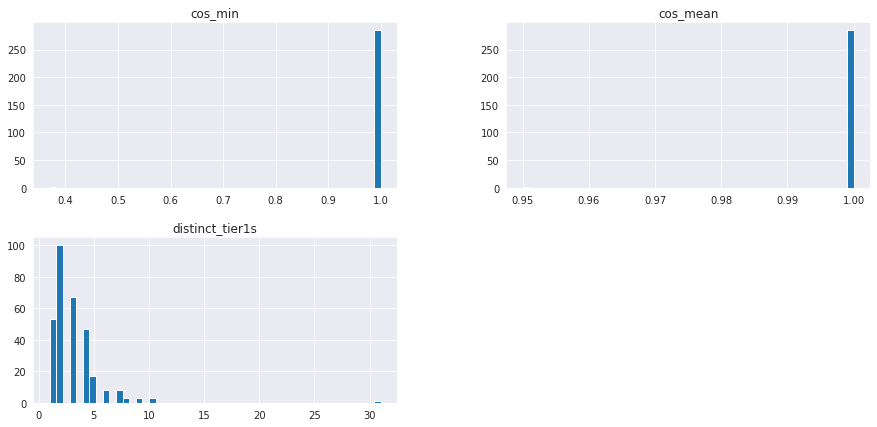

In [45]:
# TEST FOR LESSER NOISE
topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7), bins=50)
plt.show()

In [39]:
# apr26-may02, minsamples4
topic_info_may03

,Size,topic_num,cos_min,cos_mean,distinct_tier1s
0,1759,-1,0.38,0.96,30
1,103,54,1.00,1.00,12
2,90,43,1.00,1.00,14
3,49,232,1.00,1.00,7
4,44,153,1.00,1.00,6
...,...,...,...,...,...
255,1,133,NaN,NaN,1
256,1,259,NaN,NaN,1
257,1,85,NaN,NaN,1
258,1,191,NaN,NaN,1


In [46]:
# apr28-may02, minsamples4
topic_info_may03

,Size,topic_num,cos_min,cos_mean,distinct_tier1s
0,1784,-1,0.37,0.95,31
1,69,44,1.00,1.00,7
2,58,62,1.00,1.00,10
3,52,132,0.99,1.00,10
4,37,54,1.00,1.00,3
...,...,...,...,...,...
305,1,282,NaN,NaN,1
306,1,253,NaN,NaN,1
307,1,258,NaN,NaN,1
308,1,276,NaN,NaN,1


In [33]:
# apr30-may02, minsamples4
topic_info_may03

,Size,topic_num,cos_min,cos_mean,distinct_tier1s
0,1919,-1,0.22,0.95,31
1,56,38,1.00,1.00,8
2,50,101,1.00,1.00,6
3,46,143,1.00,1.00,2
4,45,127,1.00,1.00,7
...,...,...,...,...,...
230,1,229,NaN,NaN,1
231,1,230,NaN,NaN,1
232,1,59,NaN,NaN,1
233,1,193,NaN,NaN,1


In [47]:
topic_info_may03.Size.describe()

count     310.000000
mean       13.545161
std       101.228807
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max      1784.000000
Name: Size, dtype: float64

<AxesSubplot:>

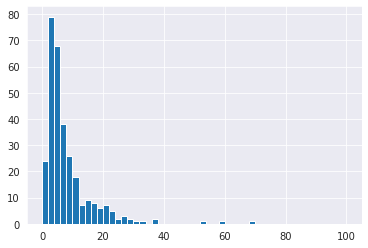

In [48]:
topic_info_may03.Size.hist(bins=50, range=(0, 100))

In [43]:
# combine natural id inside docs_df

may03_docs_df = pd.merge(may03_docs_df, may03, how="left", left_on="Doc", right_on="clean_body")
may03_docs_df.drop("clean_body", axis=1, inplace=True)

In [44]:
# combine topic_info_may03 with topic names

topic_info_may03 = pd.merge(topic_info_may03, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [101]:
pred_may03_inspect = pd.merge(may03_docs_df, 
         topic_info_may03, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

In [104]:
pred_may03_inspect.shape

(4199, 6)

In [103]:
pred_may03_inspect[pred_may03_inspect.Topic==-1]

,Doc,Topic,Size,cos_min,cos_mean,distinct_tier1s
1,"announced at wwdc, macos monterey makes the new imac even harder to resist. the new 24-inch imac is a remarkable machine; powered by apples new m1 processor, it feels modern and up-to-date in a way that imacs havent for a number of years. its now...",-1,1784,0.37,0.95,31
2,the new ipad pro 2021 gets even better with tons of new features announced at wwdc. it was just over a year ago that apple unveiled its last ipad pro. the 2020 model wasnt a significant improvement over 2018sit mainly added support for the laptop...,-1,1784,0.37,0.95,31
4,"13 pool floats for the whole family (yes, your dog too). theres only so much lemonade you can drink on your favorite lounge chair by the pool before the itch to jump in the water kicks in. but if youve been relaxing, reading or sipping on your fa...",-1,1784,0.37,0.95,31
9,"these 12 pillows for neck pain will have you waking up feeling brand new. if youre someone who suffers from chronic neck pain, it can be difficult to get a good nights sleep. and while a really great mattress can do a lot to alleviate some amount...",-1,1784,0.37,0.95,31
11,"15 aapi fashion brands to support this month and beyond. even though maythe month that asian american and pacific islander heritage month is recognizedis almost over, when you shop at the fashion retailers and brands on this list, youll also be s...",-1,1784,0.37,0.95,31
...,...,...,...,...,...,...
4187,why are manholes round? the 10 toughest interview questions. a job interview at one of google 's 75 campuses around the globe might seem to have more in common with pledging a secret fraternity than job-hunting. an often months-long interview pro...,-1,1784,0.37,0.95,31
4188,"how do you change an organizational culture?. changing an organizations culture is one of the most difficult leadership challenges. thats because an organizations culture comprises an interlocking set of goals, roles, processes, values, communica...",-1,1784,0.37,0.95,31
4191,"understanding how assets get divided in divorce. dividing the familys property during divorce can be quite difficult, especially if there are significant assets such as houses, rental property, retirement and pension plans, stock options, restric...",-1,1784,0.37,0.95,31
4194,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1,1784,0.37,0.95,31


In [46]:
len(pred_may03_inspect[pred_may03_inspect.Topic!=-1].tier1.unique())

31

In [47]:
print(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape)
pred_may03_inspect[pred_may03_inspect.Topic==-1].tier1.value_counts()

(1774, 15)


Other                       538
Business and Finance        314
Medical Health              138
Personal Finance            131
Technology & Computing      126
News and Politics            93
Video Gaming                 57
Shopping                     43
Travel                       42
Sports                       35
Food & Drink                 25
Automotive                   23
Careers                      21
Science                      20
Style & Fashion              19
Television                   18
Healthy Living               17
Education                    16
Music and Audio              16
Real Estate                  15
Movies                       12
Hobbies & Interests          12
Home & Garden                11
Events and Attractions       11
Books and Literature          7
Pop Culture                   5
Family and Relationships      4
Fine Art                      3
Pets                          1
Religion & Spirituality       1
Name: tier1, dtype: int64

In [44]:
pred_may03_inspect.to_csv(results_path + "may03pred_7daytrain.csv", index=False)

In [43]:
# TEST FOR LESSER NOISE
pred_may03_inspect.to_csv(results_path + "MOD_may03pred_7daytrain.csv", index=False)

In [48]:
# TEST FOR LESSER NOISE
pred_may03_inspect.to_csv(results_path + "MOD_HDB_may03pred_7daytrain.csv", index=False)

# droping min_samples by 1 clustered just 10 more articles

* **Predict new points/articles - May 04**

In [44]:
# dimensionality reduction
umap_embeddings_may04 = umap_embeddings.transform(may04_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may04.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4223, 2)


In [45]:
# predict

may04_test_labels, may04_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may04)

print(len(may04_test_labels))
# print(set(may04_test_labels))
print(len(set(may04_test_labels)))

4223
257


In [46]:
# put topics in dataframe
may04_docs_df = may04[['clean_body']]
may04_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may04_docs_df["Topic"] = may04_test_labels

print("Distinct topics including -1 for noise", len(may04_docs_df.Topic.unique()))
print()
may04_docs_df.tail()

Distinct topics including -1 for noise 257



,Doc,Topic
4218,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4219,"how many olympic-sized swimming pools can we fill with billionaire gold?. gold has been in the spotlight for a while now. from hovering around $300 a troy ounce in the early part of the last decade, the precious metal has more than quadrupled in ...",177
4220,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4221,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4222,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",158


In [47]:
may04_topic_sizes = extract_topic_sizes(may04_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may04_cossim_df = generate_all_cossim_metrics(may04_docs_df, umap_embeddings_may04)

# per topic - tier counts
tier_metric = may04_docs_df.join(may04[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may04 = pd.merge(pd.merge(may04_topic_sizes, 
                                        may04_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may04.drop('Topic', axis=1, inplace=True)

In [ ]:
# topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
# plt.show()

In [48]:
# combine natural id inside docs_df

may04_docs_df = pd.merge(may04_docs_df, may04, how="left", left_on="Doc", right_on="clean_body")
may04_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may04 with topic names

topic_info_may04 = pd.merge(topic_info_may04, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [49]:
pred_may04_inspect = pd.merge(may04_docs_df, 
         topic_info_may04, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may04_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",42,214,35648,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,26,1.0,1.0,6,"pillow, memory foam, sleepers, comforter, blanket, neck"


In [54]:
pred_may04_inspect.to_csv(results_path + "may04pred_7daytrain.csv", index=False)

In [51]:
# TEST FOR LESSER NOISE
pred_may04_inspect.to_csv(results_path + "MOD_may04pred_7daytrain.csv", index=False)

* **Predict new points/articles - May 05**

In [52]:
# dimensionality reduction
umap_embeddings_may05 = umap_embeddings.transform(may05_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may05.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4160, 2)


In [53]:
# predict

may05_test_labels, may05_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may05)

print(len(may05_test_labels))
# print(set(may05_test_labels))
print(len(set(may05_test_labels)))

4160
266


In [54]:
# put topics in dataframe
may05_docs_df = may05[['clean_body']]
may05_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may05_docs_df["Topic"] = may05_test_labels

print("Distinct topics including -1 for noise", len(may05_docs_df.Topic.unique()))
print()
may05_docs_df.tail()

Distinct topics including -1 for noise 266



,Doc,Topic
4155,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",103
4156,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",35
4157,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",188
4158,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,81
4159,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",158


In [55]:
may05_topic_sizes = extract_topic_sizes(may05_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may05_cossim_df = generate_all_cossim_metrics(may05_docs_df, umap_embeddings_may05)

# per topic - tier counts
tier_metric = may05_docs_df.join(may05[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may05 = pd.merge(pd.merge(may05_topic_sizes, 
                                        may05_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may05.drop('Topic', axis=1, inplace=True)

In [56]:
# combine natural id inside docs_df

may05_docs_df = pd.merge(may05_docs_df, may05, how="left", left_on="Doc", right_on="clean_body")
may05_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may05 = pd.merge(topic_info_may05, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [57]:
pred_may05_inspect = pd.merge(may05_docs_df, 
         topic_info_may05, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may05_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",42,185,28901,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,23,1.0,1.0,4,"pillow, memory foam, sleepers, comforter, blanket, neck"


In [66]:
pred_may05_inspect.to_csv(results_path + "may05pred_7daytrain.csv", index=False)

In [58]:
# TEST FOR LESSER NOISE
pred_may05_inspect.to_csv(results_path + "MOD_may05pred_7daytrain.csv", index=False)

* **Predict new points/articles - May 06**

In [59]:
# dimensionality reduction
umap_embeddings_may06 = umap_embeddings.transform(may06_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may06.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4063, 2)


In [60]:
# predict

may06_test_labels, may06_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may06)

print(len(may06_test_labels))
print(len(set(may06_test_labels)))

4063
251


In [61]:
# put topics in dataframe
may06_docs_df = may06[['clean_body']]
may06_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may06_docs_df["Topic"] = may06_test_labels

print("Distinct topics including -1 for noise", len(may06_docs_df.Topic.unique()))
print()
may06_docs_df.tail()

Distinct topics including -1 for noise 251



,Doc,Topic
4058,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4059,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",35
4060,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4061,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4062,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",-1


In [62]:
may06_topic_sizes = extract_topic_sizes(may06_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may06_cossim_df = generate_all_cossim_metrics(may06_docs_df, umap_embeddings_may06)

# per topic - tier counts
tier_metric = may06_docs_df.join(may06[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may06 = pd.merge(pd.merge(may06_topic_sizes, 
                                        may06_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may06.drop('Topic', axis=1, inplace=True)

In [63]:
# combine natural id inside docs_df

may06_docs_df = pd.merge(may06_docs_df, may06, how="left", left_on="Doc", right_on="clean_body")
may06_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may06 = pd.merge(topic_info_may06, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [64]:
pred_may06_inspect = pd.merge(may06_docs_df, 
         topic_info_may06, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may06_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"11 top-rated mattresses that will give you the best sleep of your life. a good mattress is a necessity. it keeps you comfortable at night, supports your joints while you sleep and provides a welcome resting place when youre just lounging in bed. ...",42,2842,411858,blogandpostid/blog/post/4983-60086702e0ca9e00079de673,2021-06-10,11 Top-Rated Mattresses That Will Give You The Best Sleep Of Your Life,Home & Garden,Interior Decorating,3016,22,1.0,1.0,4,"pillow, memory foam, sleepers, comforter, blanket, neck"


In [65]:
pred_may06_inspect.shape

(4063, 15)

In [66]:
# TEST FOR LESSER NOISE
pred_may06_inspect.to_csv(results_path + "MOD_may06pred_7daytrain.csv", index=False)

* **Predict new points/articles - May 07**

In [67]:
# dimensionality reduction
umap_embeddings_may07 = umap_embeddings.transform(may07_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may07.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (3630, 2)


In [68]:
# predict

may07_test_labels, may07_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may07)

print(len(may07_test_labels))
print(len(set(may07_test_labels)))

3630
246


In [69]:
# put topics in dataframe
may07_docs_df = may07[['clean_body']]
may07_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may07_docs_df["Topic"] = may07_test_labels

print("Distinct topics including -1 for noise", len(may07_docs_df.Topic.unique()))
print()
may07_docs_df.tail()

Distinct topics including -1 for noise 246



,Doc,Topic
3625,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
3626,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",35
3627,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",188
3628,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
3629,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",158


In [70]:
may07_topic_sizes = extract_topic_sizes(may07_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may07_cossim_df = generate_all_cossim_metrics(may07_docs_df, umap_embeddings_may07)

# per topic - tier counts
tier_metric = may07_docs_df.join(may07[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may07 = pd.merge(pd.merge(may07_topic_sizes, 
                                        may07_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may07.drop('Topic', axis=1, inplace=True)

In [71]:
# combine natural id inside docs_df

may07_docs_df = pd.merge(may07_docs_df, may07, how="left", left_on="Doc", right_on="clean_body")
may07_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may07 = pd.merge(topic_info_may07, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [72]:
pred_may07_inspect = pd.merge(may07_docs_df, 
         topic_info_may07, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may07_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"the best sales online right now: tatcha, best buy and more. summer doesnt officially start until june 20but thats not stopping retailers from releasing seasonal savings events. a slew of brands are either holding summer sales or offering fathers ...",46,2433,135477,blogandpostid/blog/post/4983-5f91fc0b22d6b000067a24d4,2021-06-11,"The Best Sales Online Right Now: Tatcha, Best Buy and More",Shopping,Sales and Promotions,1318,4,1.0,1.0,2,"flash deals, bedding, way day, mattresses, sale, save"


In [73]:
pred_may07_inspect.shape

(3630, 15)

In [74]:
# TEST FOR LESSER NOISE
pred_may07_inspect.to_csv(results_path + "MOD_may07pred_7daytrain.csv", index=False)

### --- Results Comparison ---

In [11]:
old_params = pd.read_csv(results_path + "MOD_may03pred_7daytrain.csv")
print(old_params.shape)
new_params = pd.read_csv(results_path + "MOD_HDB_may03pred_7daytrain.csv")
print(new_params.shape)

(4199, 15)
(4199, 15)


In [57]:
new_params[['content_natid', 'Topic', 'Size', 'cos_min', 'cos_mean', 'distinct_tier1s', 'topic_words']].head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",47,249,38804,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,11,1.0,1.0,2,"memory foam, sleepers, neck pain, foam pillow, pillows, foam mattress"


In [56]:
old_params.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",42,249,38804,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,25,1.0,1.0,6,"pillow, memory foam, sleepers, comforter, blanket, neck"


In [ ]:
# docs_df2 = docs_df.join(df[["processed_noun_2"]])
# docs_df2.head()

# # combine together all articles belonging to same cluster  
# docs_per_topic2 = docs_df2.groupby(['Topic'], as_index = False).agg({'processed_noun_2': ' '.join})

# # calculate countVector and tf-idf
# tf_idf2, count2 = c_tf_idf(docs_per_topic2.processed_noun_2.values, m=len(data))

# # top n words, topic size
# top_n_words2 = extract_top_n_words_per_topic(tf_idf2, count2, docs_per_topic2, n=20)
# topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

# # modify top_n_words per topic dict into dataframe for presentation
# topic_words_dict2 = {}  

# for k, v in top_n_words2.items():
#     topic_words_dict2[k] = ", ".join([elem[0] for elem in v])

# pd.set_option("max_colwidth", 250)
# pd.DataFrame.from_dict(topic_words_dict2, orient='index').reset_index().rename(columns={'index':'topic_num', 
#                                                                                         0:'top_20_words'}) 